###**Using Weights and Biases Platform to Optimize Hyper-Parameters for CV**
*Revised Tuesday, December 20, 2022, @author: JD Davis*

This example is dervived from a tutorial on computer vision and object recognition available on the Pytorch website here: [Building an Image Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In the tutorial here we demonstrate the following:

- How to train a convolutional neural network classifier
- Performing a Hyper-parameter Sweep
- Interacting with the dashboard, logging new results, creating reports (demonstrated and accomplished from inside Weights and Biases).  

*Let's get started!*

The first necessity is to install Weights and Biases python library.  The next step is to sign into your free Weights and Biases trial account.  The account will have a limit to the number of available runs and data storage.  If you desire to circumvent those restrictions, please use your corporate account (if you have access).  This tutorial will run in trial easily.  To sign up for a Weights and Balances trial account follow the link here: [Sign up and Find out more about W&B](https://wandb.ai/site)

So in summary to get started you need to do the following:

1. Signup for a trial account of Weights and Biases
2. Install Weights and Biases python library
3. Log-in to Weights and Biases
4. Import relevant python libraries




In [3]:
!pip install wandb -qqq

     |████████████████████████████████| 1.9 MB 35.0 MB/s 
     |████████████████████████████████| 182 kB 62.3 MB/s 
     |████████████████████████████████| 174 kB 79.0 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 173 kB 78.5 MB/s 
     |████████████████████████████████| 168 kB 81.2 MB/s 
     |████████████████████████████████| 168 kB 84.6 MB/s 
     |████████████████████████████████| 166 kB 85.2 MB/s 
     |████████████████████████████████| 166 kB 81.7 MB/s 
     |████████████████████████████████| 162 kB 69.9 MB/s 
     |████████████████████████████████| 162 kB 83.9 MB/s 
     |████████████████████████████████| 158 kB 84.7 MB/s 
     |████████████████████████████████| 157 kB 85.6 MB/s 
     |████████████████████████████████| 157 kB 85.2 MB/s 
     |████████████████████████████████| 157 kB 82.8 MB/s 
     |████████████████████████████████| 157 kB 82.5 MB/s 
     |████████████████████████████████| 157 kB 83.8 MB/s 
     |██████████

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: jenniferdavis098 (databotbox). Use `wandb login --relogin` to force relogin


True

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import wandb
import math
import random
import torch, torchvision
import torch.nn as nn

device = "cuda:0" if torch.cuda.is_available() else "cpu"

####**Setting Up Configurations**

Below we will set up two configurations.  The first will be the initial project configuration, that is what would be used if we did not run a sweep.  This configuration is used in the command `wandb.init` to initialize the project tracking.  This is present simply to set the configuration if we decide *not to do a sweep*, i.e. if we commented out all the code related to the sweep and ran our notebook.  Since we do intend to use this notebook for a sweep we will also set up the sweep configuration.


*Next we set up the sweep configuration.*  Notice we set up the following:

- method - random
- name - sweep
- metric : goals (minimize training loss)
- parameters
 - batch size - 3 choices
 - epochs - 5, 10 or 15
 - learning rate (lr) - some number between 0.1 (max) and 0.0001 (min)


**What do these variables mean?**

Well the method refers to the method by which the various parameters will be chosen.  In this instance a random method is used, but other methods can be chosen such as a ``grid search`` or a ``bayes``.  The name can be anything chosen, and parameters can vary depending on the set up of the model.  For example we could also have chosen to test various optimizers (e.g. adam, sgd) or even track other features like weights and biases.

When setting up the `sweep_id` make sure to include the project which you would like to use and to store your output.  Other advanced options include dataset versioning. We will not go through an example of this today, but rather it can be included in advanced topics.

*In the chunk of code below we do the following:*

1. Set up the `wandb` configuration
2. Set up the `sweep` configuration
3. Transform the CIFAR10 images to tensors and normalize them
4. Set up our dataloaders for training and test sets

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

wandb.init(project="CIFAR_CV_PyTorch_Example",
    config = {
  "lr": 0.001,
  "epochs": 1,
  "batch_size": 4})

config = wandb.config

## try a 'sweep' i.e. hyperparameter tuning

sweep_config = {
    'method': 'random',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'train_loss'
		},
    'parameters': {
        'batch_size': {'values': [4, 8, 16]},
        'epochs': {'values': [5, 10, 15]},
        'lr': {'max': 0.1, 'min': 0.0001}
     }
}

#
sweep_id = wandb.sweep(sweep_config, project="CIFAR_CV_PyTorch_Example")
config = wandb.config

wandb.init(project="CIFAR_CV_PyTorch_Example", config=config)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config.batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=config.batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Create sweep with ID: kyj9pacb
Sweep URL: https://wandb.ai/databotbox/CIFAR_CV_PyTorch_Example/sweeps/kyj9pacb


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Notice below we set up a ``sweep_id``.  This will create a unique id for each time we perform a sweep, and it will display the url for the sweep which will be located in your Weights and Biases account.

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="CIFAR_CV_PyTorch_Example")

Create sweep with ID: 8am51z97
Sweep URL: https://wandb.ai/databotbox/CIFAR_CV_PyTorch_Example/sweeps/8am51z97


Now let's take a quick peek at some of the images using `matplotlib` and numpy.  We can see the images and the labels.  This is what we will be using to train our CNN.

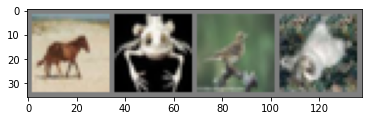

horse frog  bird  cat  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(config.batch_size)))

Below we set-up a basic neural network.  There is no alteration to the Pytorch code at this point.  Later on, we will need to add and modify the code in order to log our loss, and the results of our hyper-parameter sweep.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Now we start to make subtle changes to the code.  They are as follows:

1. The optimizer configuration for the learning rate is gleaned from the `wandb` initialization of the project (remember at the beginning we set up `wandb.config`?  

2. Instead of using a simple training loop, we write a training function called `train` in which we make the following changes:

  a. We include the wandb configuration
  
  b. We log all metrics using the command `wandb.log(metrics)`

  c. We ensure we've chosen the metrics we want to track.  In this case that includes the training loss for each epoch and the `example_ct` which represents the number of images used to train each sweep. 

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=config.lr, momentum=0.9)

In [ ]:
def train(config=None):
  with wandb.init(config=config):
    config = wandb.config
    example_ct = 0
    step_ct = 0

    for epoch in range(config.epochs):  # loop over the dataset multiple times, change back to 100

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            n_steps_per_epoch = math.ceil(len(trainloader.dataset) / config.batch_size)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
                wandb.log({"train_loss": loss.item()})

            example_ct += len(images)
            metrics = {"train/train_loss" : loss.item(),
                      "train/epoch": (i + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
                      "train/example_ct": example_ct}
            
            if i + 1 < n_steps_per_epoch:
              wandb.log(metrics)
            
            step_ct += 1

        print('Finished Training')

***Its prime time!***  

Let's start our sweep.  Below is the output from several of the sweeps.  Let's also take a look at how that will come up in our dashboard.

In [ ]:
wandb.agent(sweep_id, function=train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: dyt094ls with config:
wandb: 	batch_size: 8
wandb: 	epochs: 15
wandb: 	lr: 0.033024476383468226


[1,  2000] loss: 2.201
[1,  4000] loss: 1.825
[1,  6000] loss: 1.673
[1,  8000] loss: 1.587
[1, 10000] loss: 1.487
[1, 12000] loss: 1.449
Finished Training
[2,  2000] loss: 1.377
[2,  4000] loss: 1.364
[2,  6000] loss: 1.314
[2,  8000] loss: 1.306
[2, 10000] loss: 1.286
[2, 12000] loss: 1.264
Finished Training
[3,  2000] loss: 1.202
[3,  4000] loss: 1.207
[3,  6000] loss: 1.165
[3,  8000] loss: 1.173
[3, 10000] loss: 1.178
[3, 12000] loss: 1.158
Finished Training
[4,  2000] loss: 1.075
[4,  4000] loss: 1.096
[4,  6000] loss: 1.087
[4,  8000] loss: 1.091
[4, 10000] loss: 1.097
[4, 12000] loss: 1.089
Finished Training
[5,  2000] loss: 1.018
[5,  4000] loss: 1.014
[5,  6000] loss: 1.025
[5,  8000] loss: 1.022
[5, 10000] loss: 1.028
[5, 12000] loss: 1.030
Finished Training
[6,  2000] loss: 0.920
[6,  4000] loss: 0.982
[6,  6000] loss: 0.978
[6,  8000] loss: 0.961
[6, 10000] loss: 0.996
[6, 12000] loss: 0.991
Finished Training
[7,  2000] loss: 0.885
[7,  4000] loss: 0.914
[7,  6000] loss: 0

train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/train_loss,▆▅▃▅▅▄▂▅▂▄▄▆▅▄▄▁▂▁▂▃▇▄█▂▃▁▃▄▂▂▄▄▂▂▃▂▅▃▁▄
train_loss,▆▅▄▂▂▄▂█▅▄▂▅▂▃▃▃▅▄▅▄▃▃▃▇▅▂▅▂▂▂▁▂▂▁▂▃▂▂▂▃
train/epoch,14.99984
train/example_ct,724996
train/train_loss,1.40922
train_loss,0.90362


wandb: Agent Starting Run: 0846xgiv with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	lr: 0.03648266026108096


[1,  2000] loss: 0.617
[1,  4000] loss: 0.669
[1,  6000] loss: 0.681
[1,  8000] loss: 0.729
[1, 10000] loss: 0.724
[1, 12000] loss: 0.758
Finished Training
[2,  2000] loss: 0.609
[2,  4000] loss: 0.661
[2,  6000] loss: 0.672
[2,  8000] loss: 0.697
[2, 10000] loss: 0.715
[2, 12000] loss: 0.722
Finished Training
[3,  2000] loss: 0.610
[3,  4000] loss: 0.628
[3,  6000] loss: 0.660
[3,  8000] loss: 0.698
[3, 10000] loss: 0.718
[3, 12000] loss: 0.724
Finished Training
[4,  2000] loss: 0.604
[4,  4000] loss: 0.647
[4,  6000] loss: 0.666
[4,  8000] loss: 0.669
[4, 10000] loss: 0.696
[4, 12000] loss: 0.712
Finished Training
[5,  2000] loss: 0.575
[5,  4000] loss: 0.619
[5,  6000] loss: 0.650
[5,  8000] loss: 0.685
[5, 10000] loss: 0.686
[5, 12000] loss: 0.678
Finished Training
[6,  2000] loss: 0.570
[6,  4000] loss: 0.645
[6,  6000] loss: 0.652
[6,  8000] loss: 0.664
[6, 10000] loss: 0.680
[6, 12000] loss: 0.692
Finished Training
[7,  2000] loss: 0.567
[7,  4000] loss: 0.611
[7,  6000] loss: 0

train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train/train_loss,▁▃▂▁▃▄▄▂▁▅▁▂▄▂▁█▃▃▄▃▃▃▁▄▂▁▅▄▃▇▅▃▁▄▁▁▁▄▂▃
train_loss,▃▂▃▁▂▄▃▁▁▃▃▁▁█▂▄▁▁▂▂▁▄▄▃▅▃▄▂▄▂▃▂▂▃▁▃▇▃▃▄
train/epoch,9.99968
train/example_ct,462496
train/train_loss,0.062
train_loss,1.20383


wandb: Agent Starting Run: uepsm6jp with config:
wandb: 	batch_size: 8
wandb: 	epochs: 15
wandb: 	lr: 0.04889552719506426


[1,  2000] loss: 0.541
[1,  4000] loss: 0.585
[1,  6000] loss: 0.624
[1,  8000] loss: 0.629
[1, 10000] loss: 0.653
[1, 12000] loss: 0.650
Finished Training
[2,  2000] loss: 0.552
[2,  4000] loss: 0.577
[2,  6000] loss: 0.604
[2,  8000] loss: 0.642
[2, 10000] loss: 0.654
[2, 12000] loss: 0.639
Finished Training
[3,  2000] loss: 0.526
[3,  4000] loss: 0.558
[3,  6000] loss: 0.593
[3,  8000] loss: 0.654
[3, 10000] loss: 0.634
[3, 12000] loss: 0.655
Finished Training
[4,  2000] loss: 0.542
[4,  4000] loss: 0.556
[4,  6000] loss: 0.586
[4,  8000] loss: 0.601
[4, 10000] loss: 0.648
[4, 12000] loss: 0.635
Finished Training
[5,  2000] loss: 0.528
[5,  4000] loss: 0.553
[5,  6000] loss: 0.610
[5,  8000] loss: 0.619
[5, 10000] loss: 0.644
[5, 12000] loss: 0.638
Finished Training
[6,  2000] loss: 0.527
[6,  4000] loss: 0.554
[6,  6000] loss: 0.583
[6,  8000] loss: 0.627
[6, 10000] loss: 0.649
[6, 12000] loss: 0.646
Finished Training
[7,  2000] loss: 0.536
[7,  4000] loss: 0.554
[7,  6000] loss: 0

train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/train_loss,▁▆▁▄▃▄▃▁▄▁▄▃▄▂▃▁▂▁▄▂▇▂▁▄▂▃▁▂▂▆▁▂▂█▂▃▃▁▂▁
train_loss,▃▄▁▁▄▁▂▂▁▂▄▃▁▂▃▂▃▃▄▂▁█▄▁▂▁▄▁▄▂▁▂▂▃▁▂▂▁▄▂
train/epoch,14.99984
train/example_ct,724996
train/train_loss,0.97308
train_loss,0.44187


wandb: Agent Starting Run: 2rchotgo with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	lr: 0.0675656225850065


[1,  2000] loss: 0.534
[1,  4000] loss: 0.531
[1,  6000] loss: 0.563
[1,  8000] loss: 0.634
[1, 10000] loss: 0.620
[1, 12000] loss: 0.662
Finished Training
[2,  2000] loss: 0.517
[2,  4000] loss: 0.562
[2,  6000] loss: 0.595
[2,  8000] loss: 0.609
[2, 10000] loss: 0.600
[2, 12000] loss: 0.631
Finished Training
[3,  2000] loss: 0.537
[3,  4000] loss: 0.570
[3,  6000] loss: 0.572
[3,  8000] loss: 0.594
[3, 10000] loss: 0.580
[3, 12000] loss: 0.671
Finished Training
[4,  2000] loss: 0.538
[4,  4000] loss: 0.559
[4,  6000] loss: 0.568
[4,  8000] loss: 0.609
[4, 10000] loss: 0.596
[4, 12000] loss: 0.615
Finished Training
[5,  2000] loss: 0.516
[5,  4000] loss: 0.539
[5,  6000] loss: 0.570
[5,  8000] loss: 0.597
[5, 10000] loss: 0.651
[5, 12000] loss: 0.657
Finished Training
[6,  2000] loss: 0.511
[6,  4000] loss: 0.540
[6,  6000] loss: 0.572
[6,  8000] loss: 0.592
[6, 10000] loss: 0.620
[6, 12000] loss: 0.650
Finished Training
[7,  2000] loss: 0.488
[7,  4000] loss: 0.535
[7,  6000] loss: 0

train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/train_loss,▂▁▁▂▂▅▂▃▄▁▅▄▁▂▁▁▃▁▁▂▁▄▆▁▁▁▂▁▅▂█▃▃▅▂▂▃▂▂▂
train_loss,▄▂▂▂▁▂▁▄▂▄▄▂▅▃▂▂▁▂▂▂▆▂▃▂▃▃▂▂▁▄▂▂▅▅█▂▃▅▁▂
train/epoch,9.99984
train/example_ct,474996
train/train_loss,0.4196
train_loss,0.2935


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9g1rlu22 with config:
wandb: 	batch_size: 4
wandb: 	epochs: 10
wandb: 	lr: 0.0007490190319651517


[1,  2000] loss: 0.506
[1,  4000] loss: 0.560
[1,  6000] loss: 0.577
[1,  8000] loss: 0.631
[1, 10000] loss: 0.607
[1, 12000] loss: 0.633
Finished Training
[2,  2000] loss: 0.502
[2,  4000] loss: 0.547
[2,  6000] loss: 0.583
[2,  8000] loss: 0.588
[2, 10000] loss: 0.646
[2, 12000] loss: 0.646
Finished Training
[3,  2000] loss: 0.505
[3,  4000] loss: 0.545
[3,  6000] loss: 0.584
[3,  8000] loss: 0.602
[3, 10000] loss: 0.646
[3, 12000] loss: 0.627
Finished Training
[4,  2000] loss: 0.556
[4,  4000] loss: 0.573
[4,  6000] loss: 0.592
[4,  8000] loss: 0.595
[4, 10000] loss: 0.600
[4, 12000] loss: 0.619
Finished Training
[5,  2000] loss: 0.516
[5,  4000] loss: 0.557
[5,  6000] loss: 0.612
[5,  8000] loss: 0.636
[5, 10000] loss: 0.636
[5, 12000] loss: 0.631
Finished Training
[6,  2000] loss: 0.536
[6,  4000] loss: 0.515
[6,  6000] loss: 0.604
[6,  8000] loss: 0.621
[6, 10000] loss: 0.633
[6, 12000] loss: 0.630
Finished Training
[7,  2000] loss: 0.545
[7,  4000] loss: 0.571
[7,  6000] loss: 0

train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,▂▄▃▂▂▄▃▂▂▄▁█▃▂▁▄▁▃▃▂▃▁▁▄▃▇▂▄▁▃▃▄▂▂▃▅▁▁▁▃
train_loss,▂▄▂▁▃▁▂▃▁▁▂▄▄▂▃▁▃▁▁▁▂▁▂▁▁▃▂▁▅█▂▁▁▁▂▇▃▅▂▁
train/epoch,9.99992
train/example_ct,499996
train/train_loss,0.04329
train_loss,0.05527


wandb: Agent Starting Run: crdert99 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 15
wandb: 	lr: 0.042759356464133966


[1,  2000] loss: 0.487
[1,  4000] loss: 0.555
[1,  6000] loss: 0.598
[1,  8000] loss: 0.596
[1, 10000] loss: 0.641
[1, 12000] loss: 0.646
Finished Training
[2,  2000] loss: 0.526
[2,  4000] loss: 0.574
[2,  6000] loss: 0.618
[2,  8000] loss: 0.609
[2, 10000] loss: 0.622
[2, 12000] loss: 0.621
Finished Training
[3,  2000] loss: 0.530
[3,  4000] loss: 0.582
[3,  6000] loss: 0.527
[3,  8000] loss: 0.622
[3, 10000] loss: 0.624
[3, 12000] loss: 0.639
Finished Training
[4,  2000] loss: 0.513
[4,  4000] loss: 0.558
[4,  6000] loss: 0.622
[4,  8000] loss: 0.638
[4, 10000] loss: 0.627
[4, 12000] loss: 0.652
Finished Training
[5,  2000] loss: 0.516
[5,  4000] loss: 0.530
[5,  6000] loss: 0.599
[5,  8000] loss: 0.596
[5, 10000] loss: 0.661
[5, 12000] loss: 0.669
Finished Training
[6,  2000] loss: 0.560
[6,  4000] loss: 0.580
[6,  6000] loss: 0.611
[6,  8000] loss: 0.630
[6, 10000] loss: 0.605
[6, 12000] loss: 0.644
Finished Training
[7,  2000] loss: 0.500
[7,  4000] loss: 0.576
[7,  6000] loss: 0

train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/train_loss,▁▁▁▁▂▂▁▂▃▁▁▃▁▁▁▄▇▆▁▇▂▁▁▁▄▁▄▂▁▇▁▂▁█▅▂▆▆▂▁
train_loss,▃▂▂▁▂▃▂▂▁▁▂▁▃▁▂▃▅▁▆▃▁▁▃▁▆▂▁▂▃▅▁▄▂▁▅█▁▃▁▂
train/epoch,14.99984
train/example_ct,724996
train/train_loss,0.59843
train_loss,0.49492


wandb: Agent Starting Run: y299yh7g with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	lr: 0.06025702700639522


[1,  2000] loss: 0.566
[1,  4000] loss: 0.592
[1,  6000] loss: 0.634
[1,  8000] loss: 0.622
[1, 10000] loss: 0.635
[1, 12000] loss: 0.662
Finished Training
[2,  2000] loss: 0.544
[2,  4000] loss: 0.583
[2,  6000] loss: 0.599
[2,  8000] loss: 0.641
[2, 10000] loss: 0.669
[2, 12000] loss: 0.656
Finished Training
[3,  2000] loss: 0.585
[3,  4000] loss: 0.604
[3,  6000] loss: 0.608
[3,  8000] loss: 0.623
[3, 10000] loss: 0.621
[3, 12000] loss: 0.631
Finished Training
[4,  2000] loss: 0.552
[4,  4000] loss: 0.587
[4,  6000] loss: 0.583
[4,  8000] loss: 0.655
[4, 10000] loss: 0.660
[4, 12000] loss: 0.619
Finished Training
[5,  2000] loss: 0.567
[5,  4000] loss: 0.575
[5,  6000] loss: 0.630
[5,  8000] loss: 0.643
[5, 10000] loss: 0.604
[5, 12000] loss: 0.629
Finished Training
[6,  2000] loss: 0.585
[6,  4000] loss: 0.568
[6,  6000] loss: 0.626
[6,  8000] loss: 0.665
[6, 10000] loss: 0.673
[6, 12000] loss: 0.717
Finished Training
[7,  2000] loss: 0.539
[7,  4000] loss: 0.585
[7,  6000] loss: 0

train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/train_loss,▁▁▁▃▁▂▂▇▁▁▂▁▁▁▄▃█▂▃▅▂▂▃▁▁▂▃▁▂▂▂▂▁▂▁▂▂▁▂▂
train_loss,▂▁▅▁▁▃▁▂▁▂▃▂▃▄█▁▁▂▃▁▁▂▃▂▇▁▁▃▁▂▃▃▄▂▁▃▃▂▂▁
train/epoch,9.99984
train/example_ct,474996
train/train_loss,0.64785
train_loss,0.03839


wandb: Agent Starting Run: 1zu4jsn3 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 15
wandb: 	lr: 0.06812448267228832


[1,  2000] loss: 0.601
[1,  4000] loss: 0.580
[1,  6000] loss: 0.639
[1,  8000] loss: 0.660
[1, 10000] loss: 0.654
[1, 12000] loss: 0.680
Finished Training
[2,  2000] loss: 0.595
[2,  4000] loss: 0.590
[2,  6000] loss: 0.613
[2,  8000] loss: 0.635
[2, 10000] loss: 0.669
[2, 12000] loss: 0.656
Finished Training
[3,  2000] loss: 0.572
[3,  4000] loss: 0.624
[3,  6000] loss: 0.603
[3,  8000] loss: 0.636
[3, 10000] loss: 0.697
[3, 12000] loss: 0.695
Finished Training
[4,  2000] loss: 0.564
[4,  4000] loss: 0.595
[4,  6000] loss: 0.679
[4,  8000] loss: 0.666
[4, 10000] loss: 0.666
[4, 12000] loss: 0.668
Finished Training
[5,  2000] loss: 0.590
[5,  4000] loss: 0.629
[5,  6000] loss: 0.633
[5,  8000] loss: 0.585
[5, 10000] loss: 0.666
[5, 12000] loss: 0.707
Finished Training
[6,  2000] loss: 0.573
[6,  4000] loss: 0.604
[6,  6000] loss: 0.645
[6,  8000] loss: 0.643
[6, 10000] loss: 0.668
[6, 12000] loss: 0.661
Finished Training
[7,  2000] loss: 0.585
[7,  4000] loss: 0.631
[7,  6000] loss: 0

train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/train_loss,▁▁▁▁▃▄▅▄▄▁▁█▂▁▅▁▁▅▃▂▁▃▄▆▂▄▁▁▁▄▃▇▂▂▃▅▅▁▃▂
train_loss,█▂▂▁▄▃▄▁▄▆▇▂▁▃▄▅▂▂▄▃▂▁▁▆▁▁▁▅▂▁▂▁▃▁▇▄▁▂▂▅
train/epoch,14.99984
train/example_ct,724996
train/train_loss,1.55121
train_loss,0.99072


wandb: Agent Starting Run: r1sy90kw with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	lr: 0.04473993483415115


[1,  2000] loss: 0.542
[1,  4000] loss: 0.622
[1,  6000] loss: 0.671
[1,  8000] loss: 0.660
[1, 10000] loss: 0.674
[1, 12000] loss: 0.691
Finished Training
[2,  2000] loss: 0.630
[2,  4000] loss: 0.610
[2,  6000] loss: 0.697
[2,  8000] loss: 0.692
[2, 10000] loss: 0.674
[2, 12000] loss: 0.690
Finished Training
[3,  2000] loss: 0.608
[3,  4000] loss: 0.654
[3,  6000] loss: 0.648
[3,  8000] loss: 0.655
[3, 10000] loss: 0.665
[3, 12000] loss: 0.740
Finished Training
[4,  2000] loss: 0.634
[4,  4000] loss: 0.651
[4,  6000] loss: 0.688
[4,  8000] loss: 0.707
[4, 10000] loss: 0.672
[4, 12000] loss: 0.668
Finished Training
[5,  2000] loss: 0.652
[5,  4000] loss: 0.694
[5,  6000] loss: 0.678
[5,  8000] loss: 0.657
[5, 10000] loss: 0.725
[5, 12000] loss: 0.712
Finished Training
[6,  2000] loss: 0.619
[6,  4000] loss: 0.604
[6,  6000] loss: 0.687
[6,  8000] loss: 0.659
[6, 10000] loss: 0.734
[6, 12000] loss: 0.679
Finished Training
[7,  2000] loss: 0.609
[7,  4000] loss: 0.674
[7,  6000] loss: 0

train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/train_loss,▂▁▁▂▃▂▁▂▁▁▁▁▁▂▃▂▃▁▁▅▃▂▁█▁▁▁▂▂▁▂▁▁▁▅▂▁▁▂▃
train_loss,▁▁▄▂▃▂▄█▂▁▂▂▂▂▁▂▂▁▃▁▁▁▁▃▅▂▂▆▁▅▄▁▁▂▂▃▁▅▁▃
train/epoch,9.99984
train/example_ct,474996
train/train_loss,1.16568
train_loss,0.82164


wandb: Agent Starting Run: m9kajsji with config:
wandb: 	batch_size: 8
wandb: 	epochs: 15
wandb: 	lr: 0.06182460856926697


[1,  2000] loss: 0.641
[1,  4000] loss: 0.659
[1,  6000] loss: 0.666
[1,  8000] loss: 0.715
[1, 10000] loss: 0.731
[1, 12000] loss: 0.712
Finished Training
[2,  2000] loss: 0.583
[2,  4000] loss: 0.687
[2,  6000] loss: 0.683
[2,  8000] loss: 0.697
[2, 10000] loss: 0.706
[2, 12000] loss: 0.715
Finished Training
[3,  2000] loss: 0.620
[3,  4000] loss: 0.638
[3,  6000] loss: 0.696
[3,  8000] loss: 0.674
[3, 10000] loss: 0.724
[3, 12000] loss: 0.671
Finished Training
[4,  2000] loss: 0.637
[4,  4000] loss: 0.652
[4,  6000] loss: 0.652
[4,  8000] loss: 0.652
[4, 10000] loss: 0.700
[4, 12000] loss: 0.738
Finished Training
[5,  2000] loss: 0.657
[5,  4000] loss: 0.665
[5,  6000] loss: 0.677
[5,  8000] loss: 0.699
[5, 10000] loss: 0.745
[5, 12000] loss: 0.717
Finished Training
[6,  2000] loss: 0.579
[6,  4000] loss: 0.633
[6,  6000] loss: 0.705
[6,  8000] loss: 0.746
[6, 10000] loss: 0.737
[6, 12000] loss: 0.741
Finished Training
[7,  2000] loss: 0.658
[7,  4000] loss: 0.601
[7,  6000] loss: 0

train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/train_loss,▁▄▄▁▁▄▁▁▃▄▁▅▂▄▁▂▃▁▂▁▂▁▃▃▁▂▁▂▃▂█▂▁▄▃▃▁▃▂▄
train_loss,▄▂▁▄▁▁▂▃▁▂▂▂▂▁█▃▂▂▄▂▃▂▄▂▃▃▂▂▁▃▁▂▂▂▃▁▁▃▁▁
train/epoch,14.99984
train/example_ct,724996
train/train_loss,0.18446
train_loss,0.27786


wandb: Agent Starting Run: l3d4m69p with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	lr: 0.009731899818726504


[1,  2000] loss: 0.686
[1,  4000] loss: 0.712
[1,  6000] loss: 0.734
[1,  8000] loss: 0.730
[1, 10000] loss: 0.712
[1, 12000] loss: 0.769
Finished Training
[2,  2000] loss: 0.706
[2,  4000] loss: 0.670
[2,  6000] loss: 0.726
[2,  8000] loss: 0.819
[2, 10000] loss: 0.745
[2, 12000] loss: 0.737
Finished Training
[3,  2000] loss: 0.656
[3,  4000] loss: 0.679
[3,  6000] loss: 0.811
[3,  8000] loss: 0.754
[3, 10000] loss: 0.783
[3, 12000] loss: 0.807
Finished Training
[4,  2000] loss: 0.736
[4,  4000] loss: 0.701
[4,  6000] loss: 0.807
[4,  8000] loss: 0.740
[4, 10000] loss: 0.783
[4, 12000] loss: 0.758
Finished Training
[5,  2000] loss: 0.662
[5,  4000] loss: 0.747
[5,  6000] loss: 0.701
[5,  8000] loss: 0.728
[5, 10000] loss: 0.739
[5, 12000] loss: 0.814
Finished Training


train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇█████
train/train_loss,▂▅▂▂▁▁▂▄▄▁▁▂▁▄▃▂▂▃▂▁█▃▅▂▂▄▂▂▃▆▂▁▃▁▅▁▁▃▇▂
train_loss,▃▁▄▄▂▄▂▁▁▃▂▃▆█▄▅▂▁▃▂▂▂▄▅▁▃▁▄▅▃
train/epoch,4.99984
train/example_ct,224996
train/train_loss,0.00301
train_loss,0.82867


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hj7n7ojs with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	lr: 0.0825519525299486


[1,  2000] loss: 0.643
[1,  4000] loss: 0.708
[1,  6000] loss: 0.756
[1,  8000] loss: 0.800
[1, 10000] loss: 0.789
[1, 12000] loss: 0.753
Finished Training
[2,  2000] loss: 0.650
[2,  4000] loss: 0.650
[2,  6000] loss: 0.677
[2,  8000] loss: 0.707
[2, 10000] loss: 0.766
[2, 12000] loss: 0.782
Finished Training
[3,  2000] loss: 0.627
[3,  4000] loss: 0.722
[3,  6000] loss: 0.737
[3,  8000] loss: 0.707
[3, 10000] loss: 0.793
[3, 12000] loss: 0.692
Finished Training
[4,  2000] loss: 0.682
[4,  4000] loss: 0.781
[4,  6000] loss: 0.757
[4,  8000] loss: 0.791
[4, 10000] loss: 0.786
[4, 12000] loss: 0.831
Finished Training
[5,  2000] loss: 0.684
[5,  4000] loss: 0.774
[5,  6000] loss: 0.769
[5,  8000] loss: 0.726
[5, 10000] loss: 0.791
[5, 12000] loss: 0.833
Finished Training
[6,  2000] loss: 0.731
[6,  4000] loss: 0.760
[6,  6000] loss: 0.726
[6,  8000] loss: 0.741
[6, 10000] loss: 0.868
[6, 12000] loss: 0.817
Finished Training
[7,  2000] loss: 0.692
[7,  4000] loss: 0.705
[7,  6000] loss: 0

train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/train_loss,▂▁▂▂▂▂▄▁▄▁█▂▂▂▃▂▁▁▃▂▃▅▁▃▁▂▁▃▁▃▁▁▃▃▁▂▁▂▄▅
train_loss,▃▃▄▁▃▁▁▆█▂▂▃▂▂▁▄▂▂▂▁▂▁▂▁▇▄▂▃▁▃▁▂▃▂█▅▂▃▂▃
train/epoch,9.99984
train/example_ct,474996
train/train_loss,1.14238
train_loss,0.70926


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u0wup7k7 with config:
wandb: 	batch_size: 4
wandb: 	epochs: 5
wandb: 	lr: 0.025697730590340313


[1,  2000] loss: 0.749
[1,  4000] loss: 0.709
[1,  6000] loss: 0.755
[1,  8000] loss: 0.754
[1, 10000] loss: 0.741
[1, 12000] loss: 0.817
Finished Training
[2,  2000] loss: 0.812
[2,  4000] loss: 0.737
[2,  6000] loss: 0.771
[2,  8000] loss: 0.865
[2, 10000] loss: 0.764
[2, 12000] loss: 0.790
Finished Training
[3,  2000] loss: 0.728
[3,  4000] loss: 0.825
[3,  6000] loss: 0.800
[3,  8000] loss: 0.773
[3, 10000] loss: 0.759
[3, 12000] loss: 0.840
Finished Training
[4,  2000] loss: 0.726
[4,  4000] loss: 0.710
[4,  6000] loss: 0.715
[4,  8000] loss: 0.806
[4, 10000] loss: 0.769
[4, 12000] loss: 0.790
Finished Training


What does our dashboard look like?  Below is a snapshot of what our hyper-parameter sweep will look like.  It is an interactive dashboard, and one can hover over each line and see the hyper-paramters for that particular sweep.  If using a jupyter notebook one can also directly embed W&B dashboard elements into the notebook and watch updates in real time.  

These include:

1. Training loss versus the created sweep.
2. The relative importance of each hyper-parameter in our sweep on the outcome of the training loss.
3. A interactive visualization of the relationships between batch size, epochs and training loss.

There are a number of other visualizations in the dashboard.  Reports can also be created and shared with colleagues or supervisors.



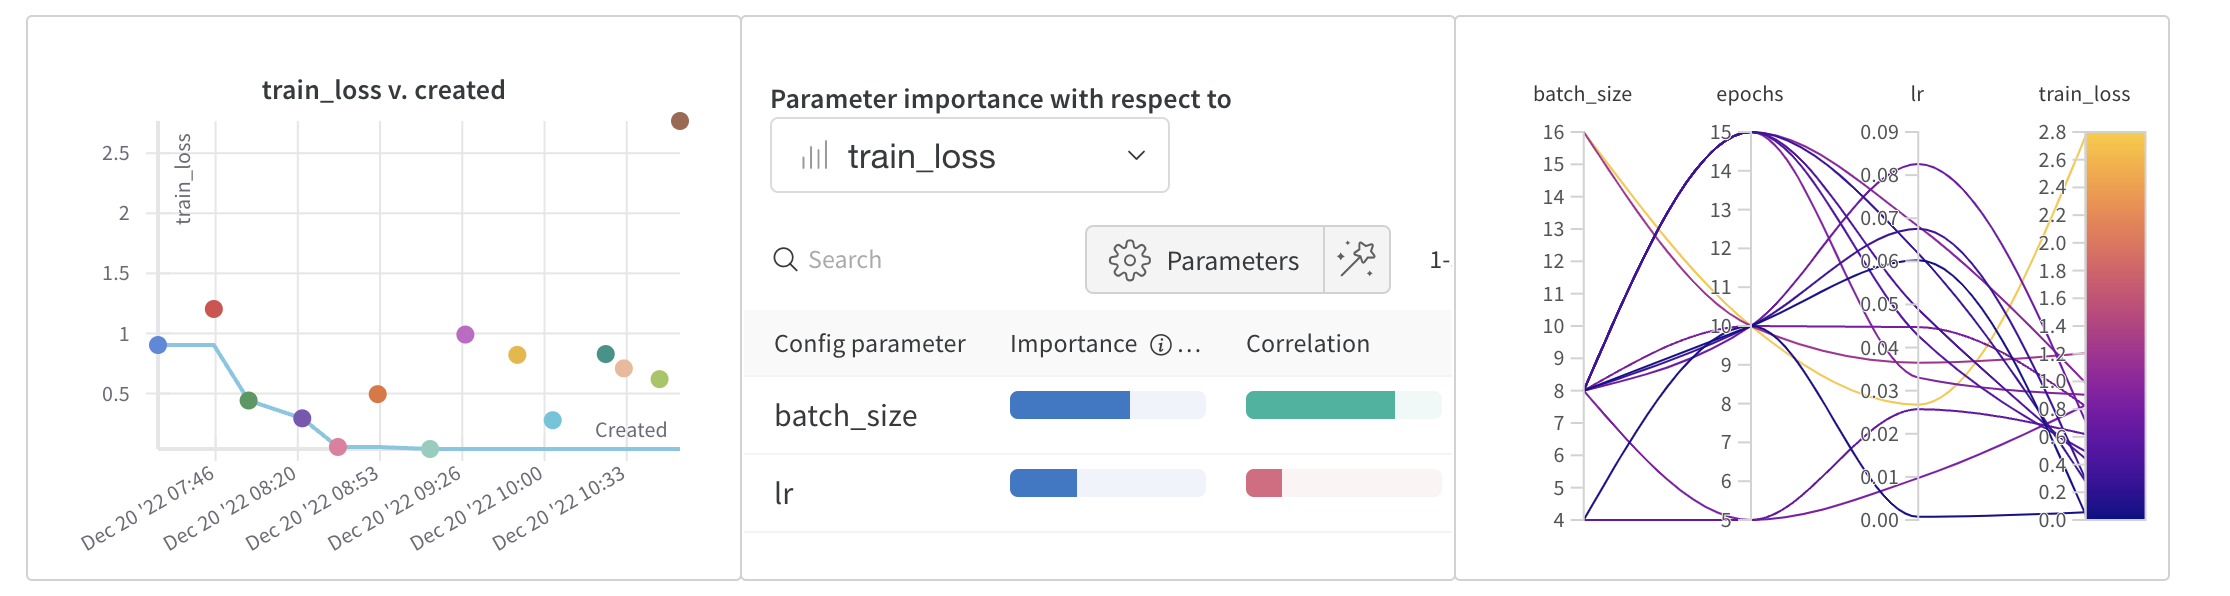

Let's take one last look at the hyper-parameter sweep up close.  Remember in yoru dash board it will be interactive, so you can hover over any of the lines and see the relative metrics (batch size, epochs, learning rate and resultant training loss).


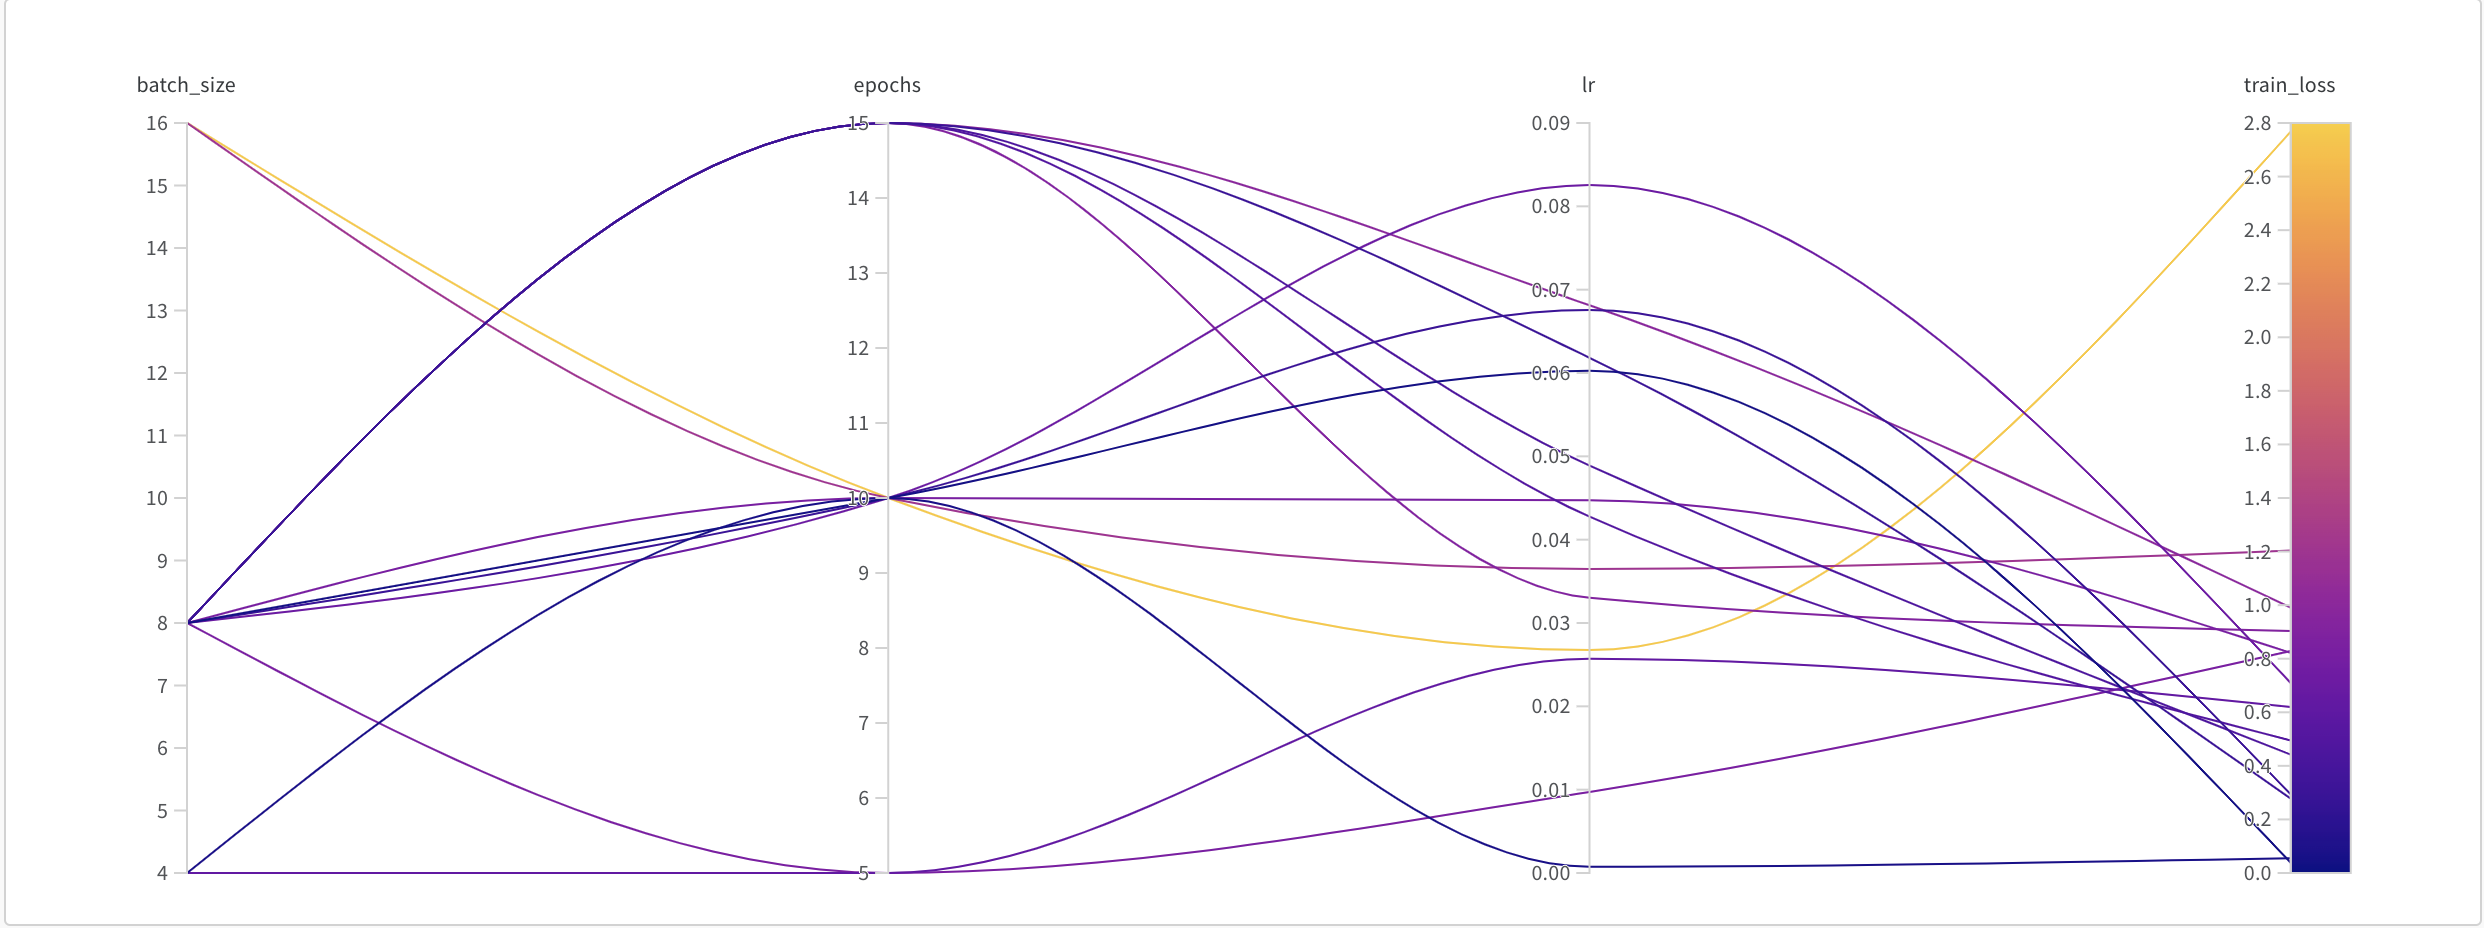

Last, but not least, we need to let the system know that we are done with our analysis.  We do that using the command `wandb.finish`.  This means that the next run, we will need to reinitialize our project.  Its a best practice to reinitilize the project and get obtain a new `sweep_id` to ensure correct versioning of your work.  The `wandb.finish()` command will not log one out of Weights and Biases instance.  You will need to log out of that using the web UI or programatically.

In [4]:
import wandb

wandb.finish()

###**References**

Hopefully you enjoyed this tutorial and found it and interesting example on how to use Weights and Biases for MLOps components including hyper-parameter tuning and versioning.

1. [PyTorch Tutorial on Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
2. [Weights & Biases Documentation](https://docs.wandb.ai/)

---



---

